In [2]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open('testSlice.json') as json_file:
    slices = json.load(json_file)

with open('testPattern.json') as json_file:
    pattern = json.load(json_file)

In [40]:
class Stmt_Expression():
    def __init__(self, expr):
        self.expr = expr
    
    def __repr__(self):
        return f"Stmt_Expression({self.expr})"

class Expr_Assign():
    def __init__(self, var, expr):
        self.var = var
        self.expr = expr
    def __repr__(self):
        return f"{self.var} = {self.expr}"
        #return f"Assignment({self.var}={self.expr})"

class Expr_FuncCall():
    def __init__(self, name, args=[]):
        self.name = name
        self.args = args
    def __str__(self):
        str_args = ", ".join(str(arg) for arg in self.args)
        return f"{self.name}({str_args})"
    def __repr__(self):
        return f"{self.name}()"
        #return f"FuncCall(name={self.name},args={self.args})"

class Expr_Variable():
    def __init__(self, name):
        self.name = name
    def __repr__(self):
        return f"${self.name}"
        #return f"Variable({self.name})"
    #def __eq__(self, other):
        # Check if the other object is an Assignment and has the same left and right values
    #    if isinstance(other, Expr_Variable) and self.name == other.name:
    #        return True
    #    return False
    #def __hash__(self):
        # Return a unique and immutable value based on the left and right values
    #    return hash(self.name)

class Constant():
    def __init__(self, value):
        self.value = value
    def __repr__(self):
        return f"Constant(value={self.value})"

class Program():
    def __init__(self, steps):
        self.steps = steps

    def __repr__(self):
        steps_str = '\n'.join(f'\t{idx}. {step}' for idx, step in enumerate(self.steps))
        return f'Program(\n{steps_str}\n)'

In [41]:
def process_json(obj):
    if isinstance(obj, dict):
        if obj["nodeType"] == 'Stmt_Expression':
            #expr = process_json(obj["expr"])
            #return Stmt_Expression(expr)
            return process_json(obj["expr"])
        if obj["nodeType"] == "Expr_Assign":
            var = process_json(obj["var"])
            expr = process_json(obj["expr"])
            return Expr_Assign(var, expr)
        if obj["nodeType"] == "Expr_FuncCall":
            name = obj["name"]["parts"][0]
            args = [process_json(arg) for arg in obj["args"]]
            return Expr_FuncCall(name, args)
        if obj["nodeType"] == "Arg":
            return process_json(obj["value"])
        if obj["nodeType"] == "Expr_Variable":
            return Expr_Variable(obj["name"])
        if obj["nodeType"] == "Scalar_String":
            return Constant(obj["value"])
    elif isinstance(obj, list):
        #for item in obj:
        steps = [process_json(step) for step in obj][:-1]
        return Program(steps)
    else:
        # obj is a scalar value (int, float, string, etc.)
        print(obj)

# Process the JSON object
parsed_ast = process_json(slices)

In [42]:
print(parsed_ast)

Program(
	0. $a = Constant(value=)
	1. $a = b()
	2. $c = $a
	3. $d = $c
	4. e($d)
	5. $c = Constant(value=)
)


In [43]:
# Function to recursively find all assignments in the AST
def find_assignments(node, graph):
    if isinstance(node, Expr_Assign):
        if graph.has_node(str(node.var)):
            # If the value of a varaible is overwritten before it is referenced anywhere
            if len(list(graph.successors(str(node.var)))) == 0:
                for u, v in list(graph.in_edges(str(node.var))):
                    graph.remove_edge(u, v)
                    graph.remove_node(u)

        # Add an edge to the graph for the assignment
        graph.add_edge(str(node.expr), str(node.var))
    if isinstance(node, Expr_FuncCall):
        # Add an edge to the graph for the assignment
        #print(node.expr)
        for arg in node.args:
            graph.add_edge(str(arg), repr(node))
    # Recurse on children
    if hasattr(node, 'steps'):
        for step in node.steps:
            find_assignments(step, graph)

# Create an empty graph
graph = nx.DiGraph()

# Find all assignments in the AST and add them to the graph
find_assignments(parsed_ast, graph)

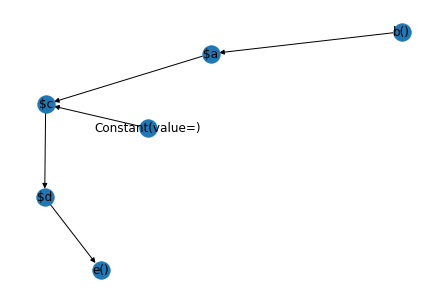

In [49]:
# Use NetworkX's draw() function to draw the graph
nx.draw(graph, with_labels=True)

# Display the graph
plt.show()

In [66]:
pattern

[{'vulnerability': 'A',
  'sources': ['b', '$c'],
  'sanitizers': [],
  'sinks': ['$d', 'e'],
  'implicit': 'yes'}]

In [72]:
def get_following_nodsanitizerses(graph, node):
    following_nodes = set()
    for _, successors in nx.dfs_successors(graph, node).items():
        following_nodes |= set(successors)
    return following_nodes

def get_following_nodes(graph, node):
    following_nodes = []
    stack = [node]
    visited = set()
    while stack:
        current_node = stack.pop()
        if current_node not in visited:
            visited.add(current_node)
            if current_node != node:
                following_nodes.append(current_node)
            stack.extend(graph.successors(current_node))
    return following_nodes

def analyze_patterns(pattern: dict, graph: nx.DiGraph) -> dict:
    output = []
    for source in pattern["sources"]:
        if "$" not in source:
            source += "()"
        following_nodes= get_following_nodes(graph, source)
        for sink in pattern["sinks"]:
            if "$" not in sink:
                sink += "()"
            if sink in following_nodes:
                sanitizers = []
                for sanitize_func in pattern["sanitizers"]:
                    if sanitize_func + "()" in following_nodes:
                        if following_nodes.index(sanitize_func + "()") < following_nodes.index(sink):      
                            sanitizers.append[sanitize_func + "()"]   
                output.append(
                    {
                        "vulnerability": pattern["vulnerability"],
                        "source": source,
                        "sink": sink,
                        "unsanitized flows": "yes" if len(sanitizers) == 0 else "no",
                        "sanitized flows": sanitizers
                    }   
                )      

    return output      


In [73]:
analyze_patterns(pattern[0], graph)

[{'vulnerability': 'A',
  'source': 'b()',
  'sink': '$d',
  'unsanitized flows': 'yes',
  'sanitized flows': []},
 {'vulnerability': 'A',
  'source': 'b()',
  'sink': 'e()',
  'unsanitized flows': 'yes',
  'sanitized flows': []},
 {'vulnerability': 'A',
  'source': '$c',
  'sink': '$d',
  'unsanitized flows': 'yes',
  'sanitized flows': []},
 {'vulnerability': 'A',
  'source': '$c',
  'sink': 'e()',
  'unsanitized flows': 'yes',
  'sanitized flows': []}]